# one-step delta learning rule

In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from utils import *

In [3]:
nsubs = 20
task = Task()
ntr,nte = 160,40
accL = [[],[]]
peL = []
nschL = []

for ci,cond in enumerate(['blocked','interleaved']):
  for s in range(nsubs):
    ag = Agent()
    exp,cur = task.generate_experiment(cond,ntr,nte)
    acc,pe = ag.forward_exp(exp) 
    accL[ci].append(acc)

acc = np.array(accL)
acc.shape # cond,subs,trials,tstep

(2, 20, 200, 2)

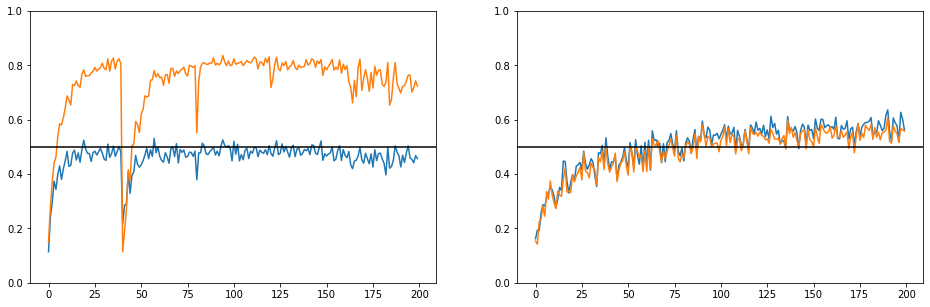

In [4]:
f,axar=plt.subplots(1,2,figsize=(16,5))
for i in range(2):
  Mac = acc[i].mean(0)
  axar[i].plot(Mac)
  axar[i].set_ylim(0,1)
  axar[i].axhline(0.5,c='k')


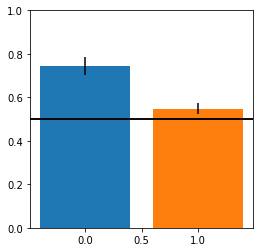

In [5]:
f,axar=plt.subplots(1,1,figsize=(4,4))
tstep = 1
for i in range(2):
  Mac = acc[i].mean(0)
  Sac = acc[i].std(0)/np.sqrt(len(acc[i]))
  axar.set_ylim(0,1)
  axar.axhline(0.5,c='k')
  axar.bar(i,Mac[-40:,tstep].mean(),yerr=Sac[-40:,tstep].mean())